In [2]:
import pandas as pd
import numpy as np
import qstock as qs
import matplotlib.pyplot as plt
#VAR模型和单位根检验
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
#协整分析
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#VECM分析
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
#格兰杰因果检验
from statsmodels.tsa.stattools import grangercausalitytests
#过滤警告信息
import warnings
warnings.filterwarnings('ignore')
#获取价格数据
codes=['沪深300ETF','国债ETF','大宗商品ETF']
df = qs.get_price(codes,end='20230619').dropna()
# 判断序列是否平稳，如果不平稳需要进行差分
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1] < 0.05
# 差分直到序列平稳
def difference_until_stationary(df):
    while not df.apply(test_stationarity).all():
        df = df.diff().dropna()
    return df
#df_diff = difference_until_stationary(df)
#对数收益率，一般是平稳序列
returns=np.log(df/df.shift(1)).dropna()

In [2]:
# 建立VAR模型
model = VAR(endog=returns)
lags = range(1, 10)  # consider lag lengths from 1 to 10
criterion = 'aic'  # or 'bic'

# 使用循环计算每个滞后阶数的AIC或BIC值
criteria = []
for lag in lags:
    result = model.fit(lag)
    criteria.append(result.info_criteria[criterion])

# 找到AIC或BIC值最小的滞后阶数
best_lag = lags[criteria.index(min(criteria))]
# 估计模型参数
results = model.fit(best_lag)
# 输出VAR回归结果
#print(results.summary())

In [3]:
def show_result(df):
    # 创建一个空的DataFrame来保存结果
    results_df = pd.DataFrame()
    # 对每个自变量进行操作
    for var in results.names:
        # 获取该自变量的系数和统计值
        coeffs = results.params[var].round(3)
        pvalues = results.pvalues[var].round(3)
        # 将系数和统计值放入DataFrame
        for i in range(len(pvalues)):
            if pvalues[i]<0.01:
                coeffs[i]=str(coeffs[i])+'***'
            elif pvalues[i]<0.05:
                coeffs[i]=str(coeffs[i])+'**'
            elif pvalues[i]<0.1:
                coeffs[i]=str(coeffs[i])+'*'
        results_df[var + '_coeff'] = coeffs
        results_df[var + '_pvalue'] = pvalues
    return results_df
show_result(results)

,大宗商品ETF_coeff,大宗商品ETF_pvalue,国债ETF_coeff,国债ETF_pvalue,沪深300ETF_coeff,沪深300ETF_pvalue
const,-0.0,0.810,0.0***,0.001,0.0,0.635
L1.大宗商品ETF,-0.172***,0.000,-0.003,0.200,0.013,0.560
L1.国债ETF,0.27,0.225,0.08***,0.000,0.129,0.505
L1.沪深300ETF,0.338***,0.000,-0.002,0.527,0.012,0.636
L2.大宗商品ETF,-0.09***,0.000,-0.004*,0.060,-0.054**,0.015
L2.国债ETF,0.272,0.224,-0.019,0.355,0.006,0.975
L2.沪深300ETF,0.09***,0.003,0.003,0.292,-0.049*,0.062
L3.大宗商品ETF,-0.045*,0.080,0.001,0.729,-0.027,0.228
L3.国债ETF,0.484**,0.030,-0.03,0.144,0.341*,0.078
L3.沪深300ETF,0.066**,0.027,-0.004,0.185,0.008,0.762


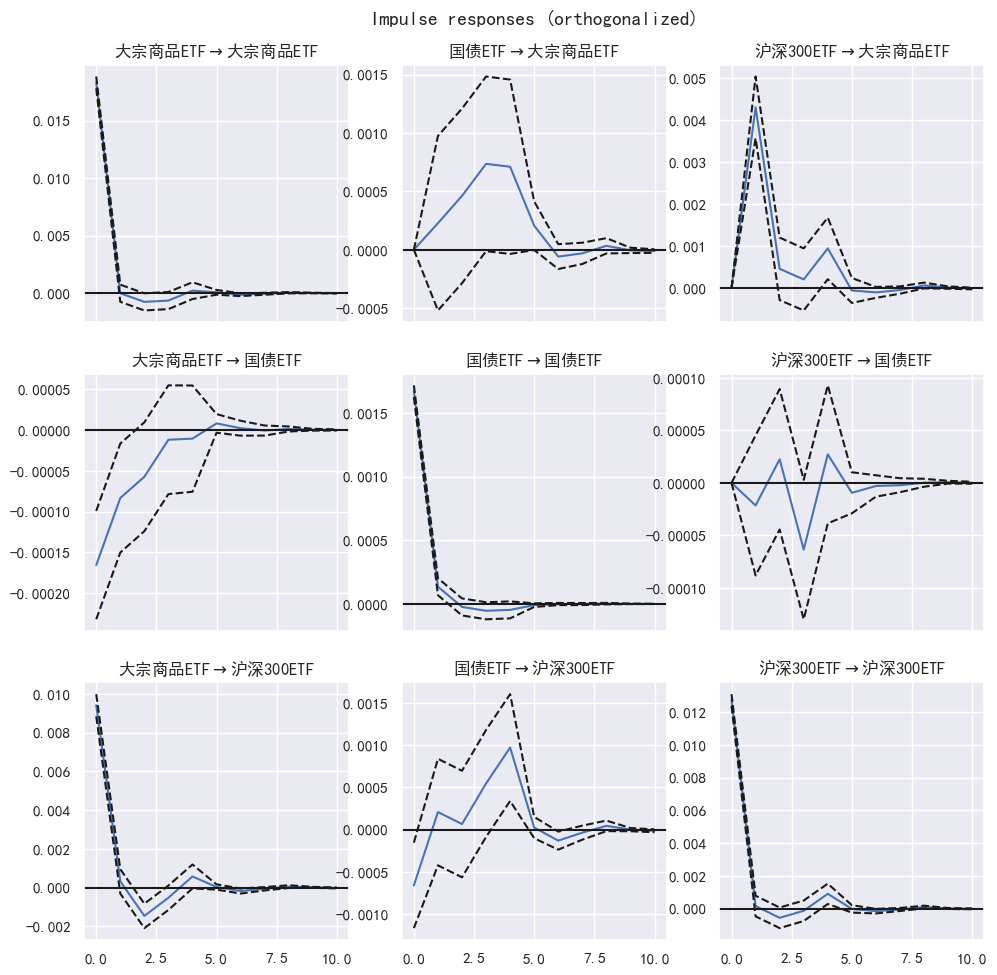

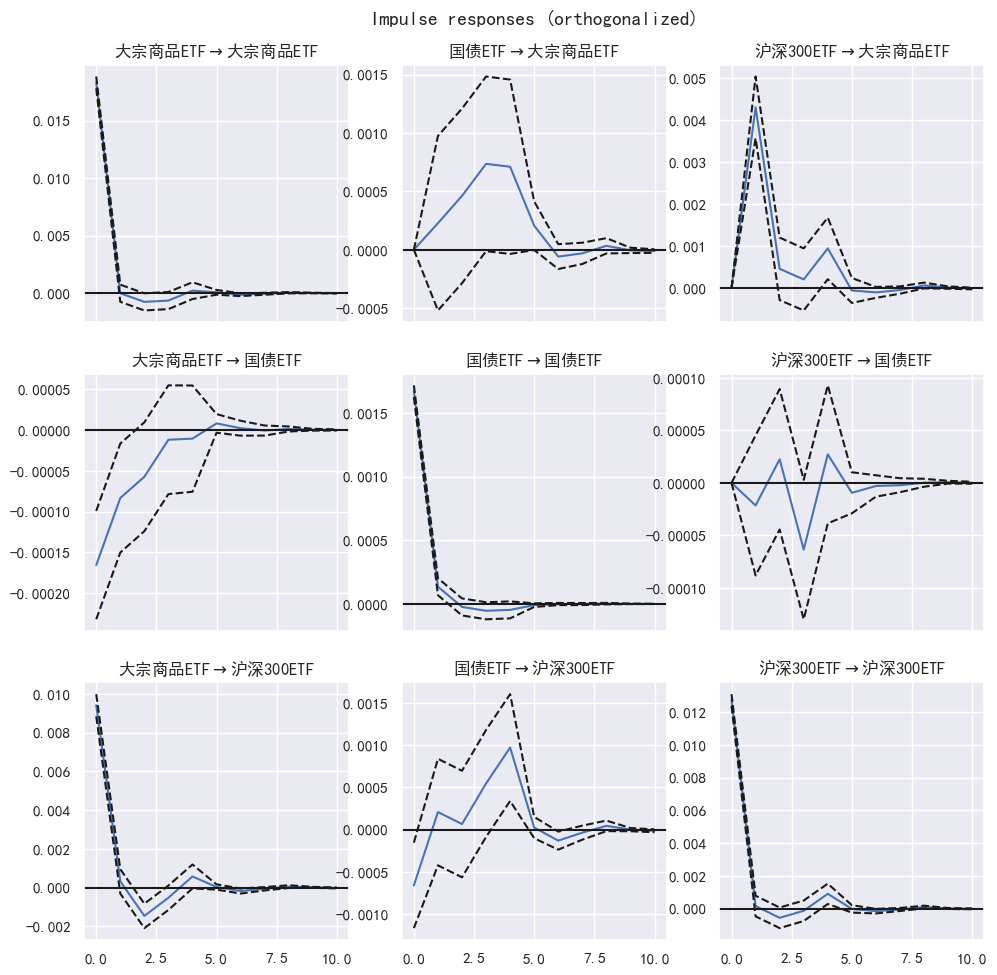

In [4]:
# 预测
forecast = results.forecast(returns.values[-best_lag:], steps=10)  # 预测未来10个时间步长
# 脉冲响应分析
irf = results.irf(10)  # 计算脉冲响应函数
irf.plot(orth=True)  # 绘制脉冲响应函数图表

In [6]:
#基于coint的协整检验
def check_coint(df):
    '''df是包含两个序列的dataframe'''
    s1=df.iloc[:,0]
    s2=df.iloc[:,1]
    coint_t, p_value, crit_value = coint(s1,s2)
    if p_value < 0.05:
        return True
    else:
        return False
#基于Johansen的协整检验
def check_johansen(df):
    '''df是包含两个序列的dataframe'''
    # 进行Johansen协整检验
    johansen_test = coint_johansen(df.values, det_order=0, k_ar_diff=1)
    # 判断是否存在协整关系
    if johansen_test.lr1[0] > johansen_test.cvt[0, 1]:  # 5%显著性水平
        return True
    else:
        return False

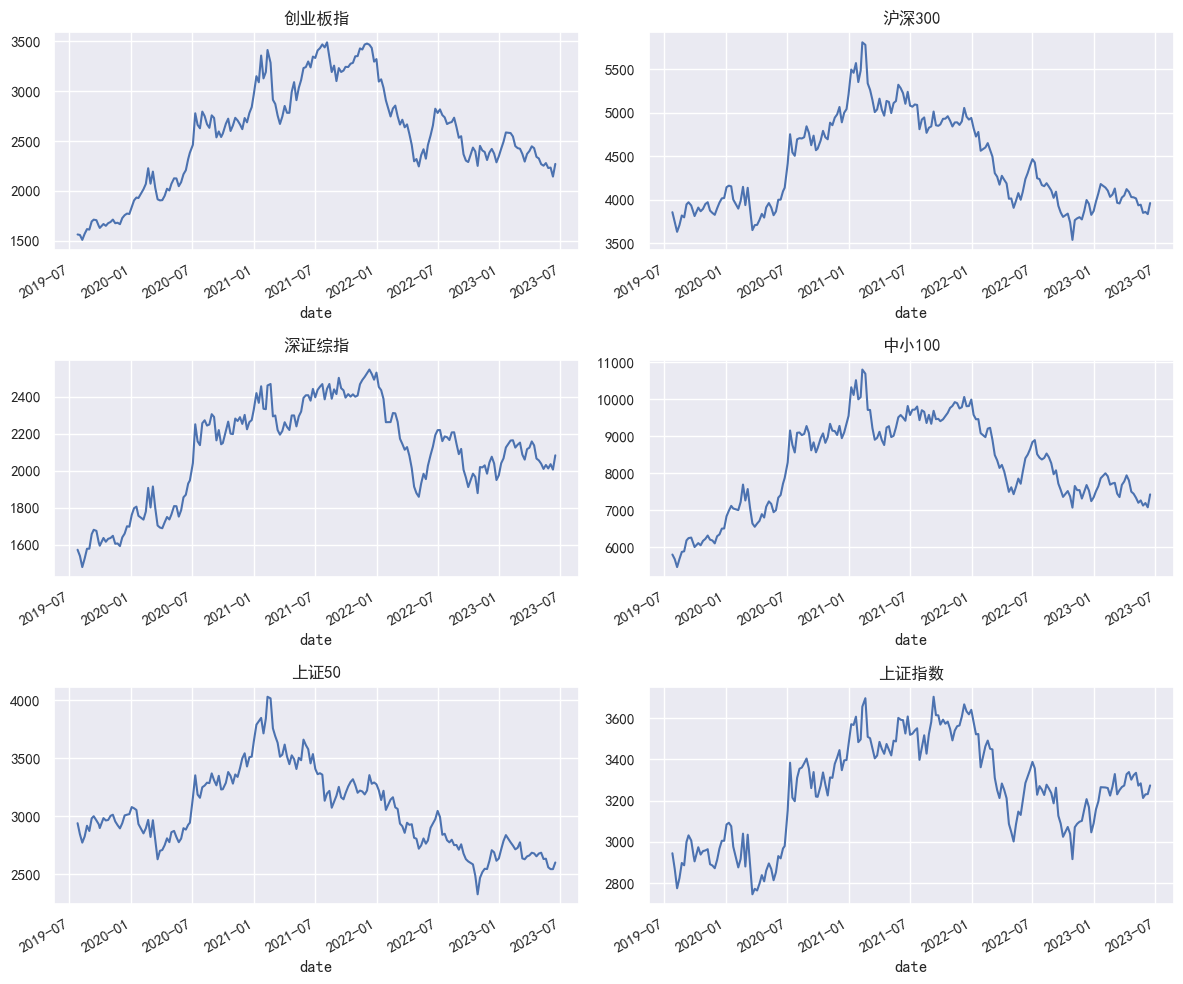

In [9]:
#获取指数最近200个周价格数据
codes=['sh','sz','sz50','cyb','hs300','zxb']
data=qs.get_price(codes,end='20230620',freq='w').dropna()[-200:]
#价格走势对比
fig,ax=plt.subplots(3,2,figsize=(12,10))
k=0
for i in range(3):
    for j in range(2):
        data.iloc[:,k].plot(ax=ax[i,j]);
        ax[i,j].set_title(data.columns[k]);
        k+=1
plt.tight_layout()

In [13]:
import itertools
ss = [list(i) for i in list(itertools.combinations(data.columns,2))]
for i in range(len(ss)):
    if check_coint(data[ss[i]]):
        print('After coint check',f'{ss[i]}存在协整关系')
        
#['深证综指','创业板指']存在协整关系
#['创业板指','上证指数']存在协整关系
for i in range(len(ss)):
    if check_johansen(data[ss[i]]):
        print('After johansen check 'f'{ss[i]}存在协整关系')
        
#['深证综指','创业板指']存在协整关系
#['深证综指','上证指数']存在协整关系
#['创业板指','上证指数']存在协整关系

After coint check ['创业板指', '上证指数']存在协整关系
After coint check ['深证综指', '上证指数']存在协整关系
After johansen check ['创业板指', '深证综指']存在协整关系
After johansen check ['创业板指', '上证指数']存在协整关系
After johansen check ['深证综指', '上证指数']存在协整关系


Eigenvalues:  [25.24651436  6.73976323]
Critical values: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation 深证综指
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.深证综指       -0.0890      0.166     -0.536      0.592      -0.415       0.237
L1.上证指数        0.0109      0.135      0.081      0.936      -0.254       0.276
Det. terms outside the coint. relation & lagged endog. parameters for equation 上证指数
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.深证综指       -0.1511      0.204     -0.742      0.458      -0.551       0.248
L1.上证指数        0.0018      0.166      0.011      0.991      -0.323       0.327
                Loading coefficients (alpha) for equation 深证综指                
         

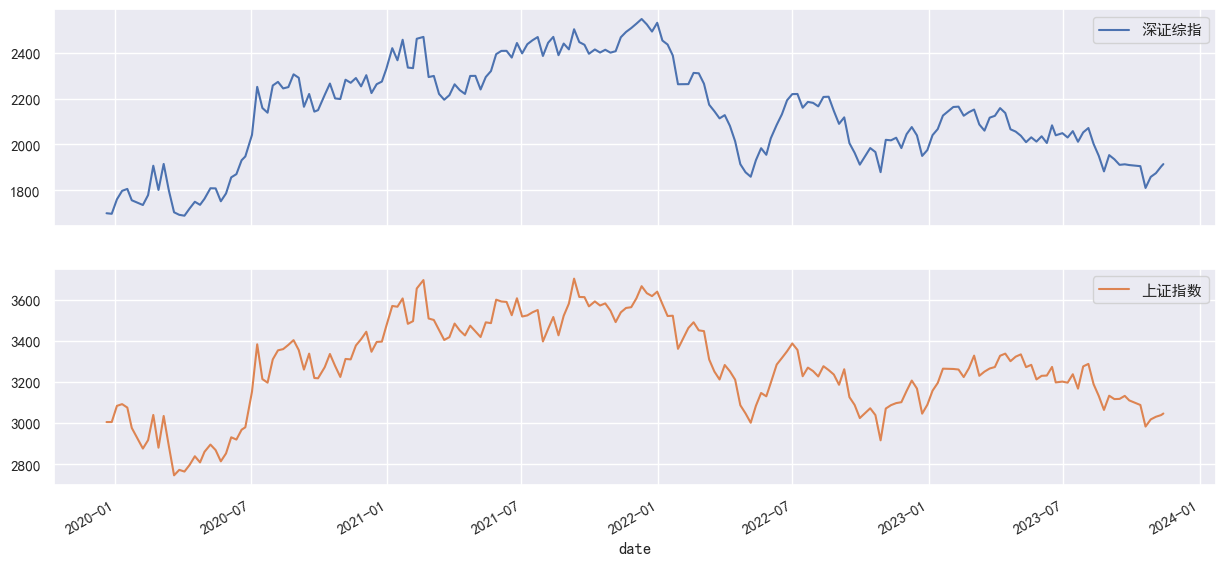

In [20]:
data = qs.get_price(['sh','sz'],freq = 'w').dropna()[-200:]
                    
johansen_test = coint_johansen(data,det_order = 0,k_ar_diff = 1)
print('Eigenvalues: ',johansen_test.lr1)
print('Critical values:',johansen_test.cvt)
                    
vecm = VECM(data,coint_rank = 1)
vecm_fit = vecm.fit()

print(vecm_fit.summary())
                    
pred = vecm_fit.predict(steps = 5)
print('Predictions: \n',pred)
                    
data.plot(subplots=True,figsize=(15,7));

In [7]:
np.random.seed(123)
X = np.random.normal(size=1000)
Y = np.roll(X,shift=-1) + np.random.normal(size=1000)
data = np.column_stack([X,Y])
results = grangercausalitytests(data,maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1237.5676, p=0.0000  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=1241.2952, p=0.0000  , df=1
likelihood ratio test: chi2=806.8005, p=0.0000  , df=1
parameter F test:         F=1237.5676, p=0.0000  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=618.6395, p=0.0000  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=1243.5090, p=0.0000  , df=2
likelihood ratio test: chi2=807.5330, p=0.0000  , df=2
parameter F test:         F=618.6395, p=0.0000  , df_denom=993, df_num=2


In [11]:
np.random.seed(123)
X = np.random.normal(size=10000)
Y = np.random.normal(size=10000)
data = np.vstack([X,Y]).T
results = grangercausalitytests(data,maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9768  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9768  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9768  , df=1
parameter F test:         F=0.0008  , p=0.9768  , df_denom=9996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0488  , p=0.9524  , df_denom=9993, df_num=2
ssr based chi2 test:   chi2=0.0976  , p=0.9524  , df=2
likelihood ratio test: chi2=0.0976  , p=0.9524  , df=2
parameter F test:         F=0.0488  , p=0.9524  , df_denom=9993, df_num=2


In [13]:
data=qs.get_price(['sh','sz']).dropna()
returns=data.pct_change().dropna()
for column in data.columns:
    result = adfuller(data[column])
    if result[1]>0.05:
            print(f"{column}非平稳，需要差分")
    else:
        print(f"{column}平稳")
        
model = VAR(returns)
lag_order = model.select_order(maxlags=10)
print(f"最大滞后阶数：{lag_order.selected_orders['aic']}")

maxlag = lag_order.selected_orders['aic']
test_result = grangercausalitytests(data,maxlag=maxlag)

深证综指非平稳，需要差分
上证指数非平稳，需要差分
最大滞后阶数：10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0009  , p=0.9755  , df_denom=6671, df_num=1
ssr based chi2 test:   chi2=0.0009  , p=0.9755  , df=1
likelihood ratio test: chi2=0.0009  , p=0.9755  , df=1
parameter F test:         F=0.0009  , p=0.9755  , df_denom=6671, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0817  , p=0.0459  , df_denom=6668, df_num=2
ssr based chi2 test:   chi2=6.1680  , p=0.0458  , df=2
likelihood ratio test: chi2=6.1651  , p=0.0458  , df=2
parameter F test:         F=3.0817  , p=0.0459  , df_denom=6668, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4690  , p=0.0601  , df_denom=6665, df_num=3
ssr based chi2 test:   chi2=7.4147  , p=0.0598  , df=3
likelihood ratio test: chi2=7.4105  , p=0.0599  , df=3
parameter F test:         F=2.4690  , p=0.0601  , df_denom=6665, df_num=3

Granger Causality
number of lags (no zero) 4
ssr ba

In [14]:
model_fitted = model.fit(maxlags=maxlag)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, Nov, 2023
Time:                     10:37:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.0475
Nobs:                     6664.00    HQIC:                  -18.0755
Log likelihood:           41407.4    FPE:                1.39143e-08
AIC:                     -18.0903    Det(Omega_mle):     1.38270e-08
--------------------------------------------------------------------
Results for equation 深证综指
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000471         0.000215            2.189           0.029
L1.深证综指          0.099655         0.028527            3.493           0.000
L1.上证指数         -0.059641         0.031952           -1.867           0.062
L2.深证